In [1]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops
import pickle
import copy
import random
from util.utils import slprint, to_device
import util.misc as utils
from engine import evaluate
from torch.utils.data import DataLoader
from datasets import build_dataset, get_coco_api_from_dataset


## dataset and prediction

In [2]:
scale_config = "5scale"
model_config_path = "config/DINO/DINO_" + scale_config + ".py" # change the path of the model config file
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
args.dataset_file = 'coco'
args.coco_path = "../coco/" # the path of coco
args.fix_size = False
dataset_val = build_dataset(image_set='val', args=args)

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


In [3]:
dataset_val[1000][1].keys()

dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd', 'orig_size', 'size'])

In [4]:
# result_path = "./results/deep_ensemble/DINO_0031_5scale.pkl"
# with open(result_path, "rb") as outfile:
#     predictions = pickle.load(outfile)

In [5]:
result_path = "./results/deep_ensemble/"
consider_model_results = {"DINO_0011_4scale.pkl", "DINO_0011_5scale.pkl", "DINO_0023_4scale.pkl", "DINO_0022_5scale.pkl", "DINO_0033_4scale.pkl", "DINO_0031_5scale.pkl"}
ego_model_index = 5
deep_ensemble_results = []
for path in consider_model_results:
    temp_path = result_path + path
    with open(temp_path, "rb") as outfile:
         deep_ensemble_results.append(pickle.load(outfile))

## display

In [6]:
from collections import defaultdict
import json
import numpy as np
class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)
            
        self.annIm_dict = defaultdict(list)        
        self.cat_dict = {} 
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}
        for ann in coco['annotations']:           
            self.annIm_dict[ann['image_id']].append(ann) 
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        for license in coco['licenses']:
            self.licenses_dict[license['id']] = license
    def get_imgIds(self):
        return list(self.im_dict.keys())
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]        
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]
    def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]

In [7]:
coco_annotations_file="../coco/annotations/instances_val2017.json"
coco_images_dir="../coco/val2017"
coco= COCOParser(coco_annotations_file, coco_images_dir)

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# define a list of colors for drawing bounding boxes
color_list = ["pink", "black", "blue", "orange", "yellow", "magenta","aqua"]
score_threshold = 0
# len(selected_img_ids) should be even.
def display_coco_image(selected_img_ids, dataset_ids):
    # num_imgs_to_disp = 4
    # total_images = len(coco.get_imgIds()) # total number of images
    # sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]
    # img_ids = coco.get_imgIds()
    # selected_img_ids = [img_ids[i] for i in sel_im_idxs]
    ann_ids = coco.get_annIds(selected_img_ids)
    im_licenses = coco.get_imgLicenses(selected_img_ids)
    fig, ax = plt.subplots(nrows=len(selected_img_ids)//2, ncols=2, figsize=(15,10))
    ax = ax.ravel()
    for i, im in enumerate(selected_img_ids):
        image = Image.open(f"{coco_images_dir}/{str(im).zfill(12)}.jpg")
        ann_ids = coco.get_annIds(im)
        annotations = coco.load_anns(ann_ids)
        for ann in annotations:
            bbox = ann['bbox']
            x, y, w, h = [int(b) for b in bbox]
            class_id = ann["category_id"]
            class_name = coco.load_cats(class_id)[0]["name"]
            license = coco.get_imgLicenses(im)[0]["name"]
            color_ = "red"
            rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
            t_box=ax[i].text(x, y, class_name,  color=color_, fontsize=10)
            t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
            ax[i].add_patch(rect)
        
        id = dataset_ids[i]
        pred_logits = deep_ensemble_results[ego_model_index][id]['pred_logits']
        pred_boxes = deep_ensemble_results[ego_model_index][id]['pred_boxes']
        select_mask = pred_logits > score_threshold
        select_idx_all = np.reshape(select_mask, -1).nonzero()[0]
        select_idx = select_idx_all // pred_logits.shape[2]
        lables = select_idx_all % pred_logits.shape[2]
        pred_boxes = np.squeeze(pred_boxes[:, select_idx], axis=0)
        lx = dataset_val[id][1]['orig_size'].tolist()
        lx = np.array([lx[1], lx[0], lx[1], lx[0]])
        pred_boxes = pred_boxes * lx
        if len(pred_boxes.shape) > 1:
            pred_boxes[:,:2] = pred_boxes[:,:2] - (pred_boxes[:,2:] / 2)
        for object_id in range(lables.shape[0]):
            x, y, w, h = [int(b) for b in pred_boxes[object_id]]
            class_name = coco.load_cats(lables[object_id])[0]["name"]
            color_ = "green"
            rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
            t_box=ax[i].text(x+w/2, y, class_name,  color=color_, fontsize=10)
            t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
            ax[i].add_patch(rect)
        
        for model_idx in range(len(deep_ensemble_results)):
            if model_idx == ego_model_index:
                continue
            pred_logits = deep_ensemble_results[model_idx][id]['pred_logits']
            pred_boxes = deep_ensemble_results[model_idx][id]['pred_boxes']
            select_mask = pred_logits > score_threshold
            select_idx_all = np.reshape(select_mask, -1).nonzero()[0]
            select_idx = select_idx_all // pred_logits.shape[2]
            lables = select_idx_all % pred_logits.shape[2]
            pred_boxes = np.squeeze(pred_boxes[:, select_idx], axis=0)
            lx = dataset_val[id][1]['orig_size'].tolist()
            lx = np.array([lx[1], lx[0], lx[1], lx[0]])
            pred_boxes = pred_boxes * lx
            if len(pred_boxes.shape) > 1:
                pred_boxes[:,:2] = pred_boxes[:,:2] - (pred_boxes[:,2:] / 2)
            for object_id in range(lables.shape[0]):
                x, y, w, h = [int(b) for b in pred_boxes[object_id]]
                class_name = coco.load_cats(lables[object_id])[0]["name"]
                color_ = color_list[model_idx]
                rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
                t_box=ax[i].text(x, y, class_name,  color=color_, fontsize=10)
                t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
                ax[i].add_patch(rect)
        
        ax[i].axis('off')
        ax[i].imshow(image)
        ax[i].set_xlabel('Longitude')
        ax[i].set_title(str(im))
    plt.tight_layout()
    plt.show()
    
def find_image_ids(dataset_ids):
    selected_img_ids = [int(dataset_val[i][1]['image_id']) for i in dataset_ids]
    return selected_img_ids

def display_with_dataset_ids(dataset_ids):
    selected_img_ids = find_image_ids(dataset_ids)
    print(selected_img_ids)
    display_coco_image(selected_img_ids, dataset_ids)

## ASE Classification

[180296, 179392]


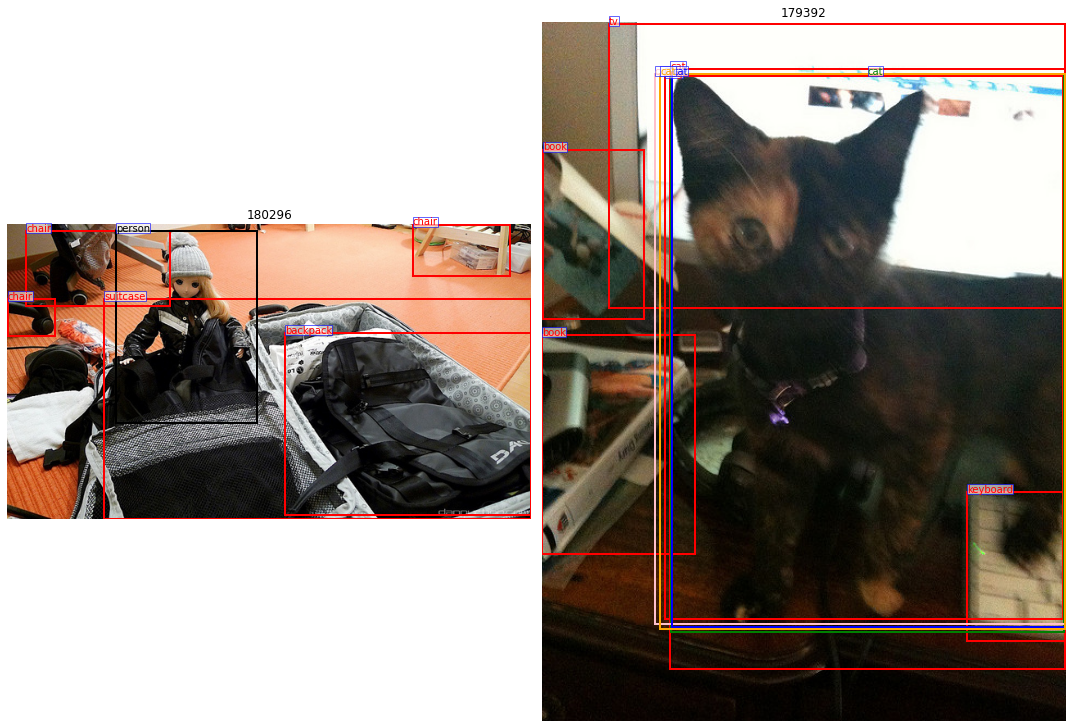

In [9]:
# Top 10 largest q
# dataset_ids = [1563, 1553, 4508,  402, 4506, 4502, 4500,  409, 3079, 3627]
dataset_ids = [1563, 1553]
display_with_dataset_ids(dataset_ids)

[541055, 61268]


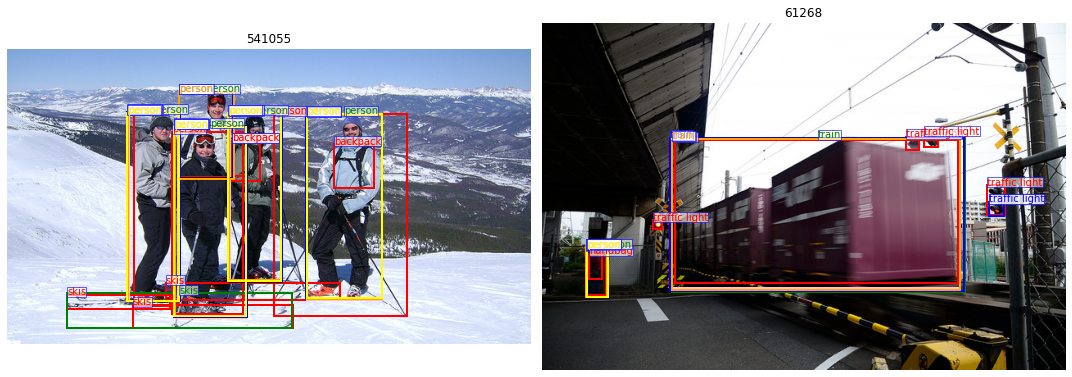

In [14]:
# Top 10 smallest q
# dataset_ids = [4652,  540, 1766, 2447,  163, 3879, 4068, 3786, 2434,  414]
display_with_dataset_ids([4652,  540])

## ASE Regression

[226662, 333237]


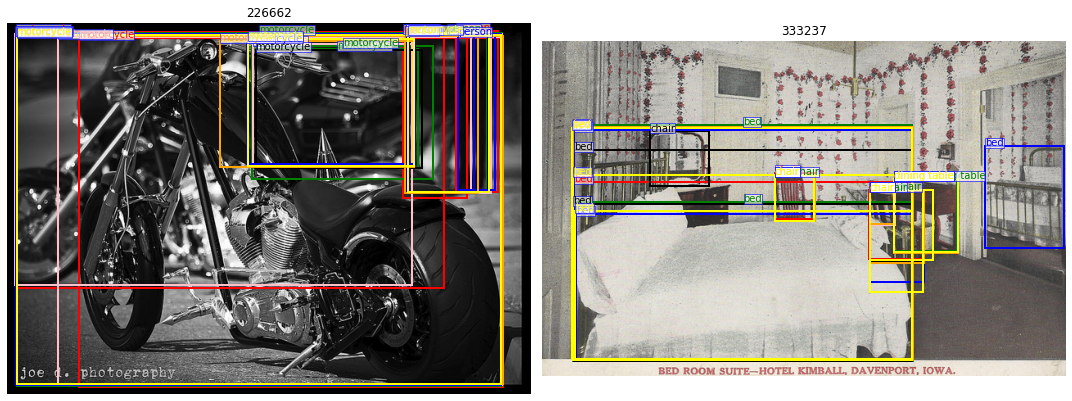

In [30]:
# Top 10 largest q
# dataset_ids = [1969, 2874, 4685, 1019, 2862, 2861, 2856, 2832, 1961, 4439]
score_threshold = -1
dataset_ids = [1969, 2874]
display_with_dataset_ids(dataset_ids)

[421455, 350833]


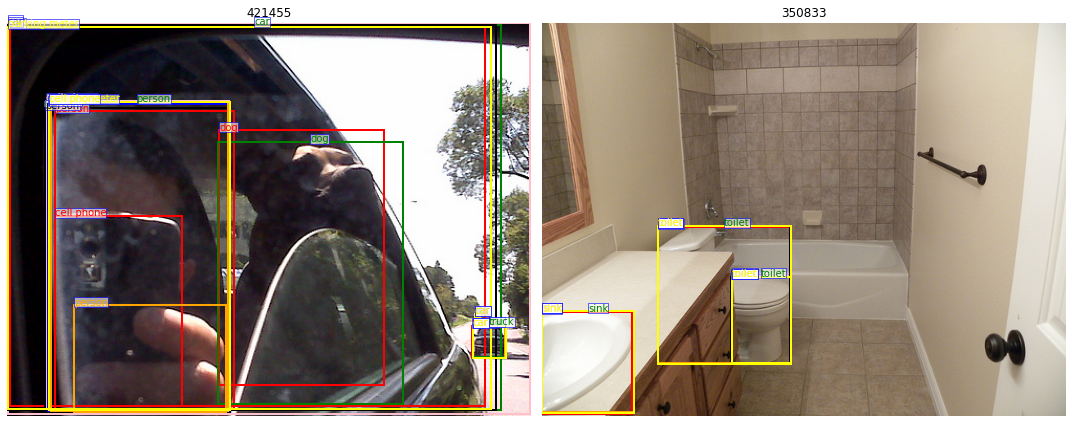

In [31]:
# Top 10 smallest q
# dataset_ids = [298, 2948, 732, 4153, 228, 3158, 288, 4397, 3636, 3032]
dataset_ids = [3636, 3032]
display_with_dataset_ids(dataset_ids)

## Show for box-based active testing 

In [31]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# define a list of colors for drawing bounding boxes
color_list = ["pink", "black", "blue", "orange", "yellow", "magenta","aqua"]
score_threshold = 0
# len(selected_img_ids) should be even.
def display_coco_image(selected_img_ids, dataset_ids):
    # num_imgs_to_disp = 4
    # total_images = len(coco.get_imgIds()) # total number of images
    # sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]
    # img_ids = coco.get_imgIds()
    # selected_img_ids = [img_ids[i] for i in sel_im_idxs]
    ann_ids = coco.get_annIds(selected_img_ids)
    im_licenses = coco.get_imgLicenses(selected_img_ids)
    fig, ax = plt.subplots(nrows=len(selected_img_ids)//2, ncols=2, figsize=(15,10))
    ax = ax.ravel()
    for i, im in enumerate(selected_img_ids):
        image = Image.open(f"{coco_images_dir}/{str(im).zfill(12)}.jpg")
        # ann_ids = coco.get_annIds(im)
        # annotations = coco.load_anns(ann_ids)
        # # for ann in annotations:
        # ann = annotations[1]
        # bbox = ann['bbox']
        # x, y, w, h = [int(b) for b in bbox]
        # class_id = ann["category_id"]
        # class_name = coco.load_cats(class_id)[0]["name"]
        # license = coco.get_imgLicenses(im)[0]["name"]
        # color_ = "red"
        # rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
        # t_box=ax[i].text(x, y, class_name,  color=color_, fontsize=10)
        # t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        # ax[i].add_patch(rect)
        
        ax[i].axis('off')
        ax[i].imshow(image)
        ax[i].set_xlabel('Longitude')
        ax[i].set_title(str(im))
    plt.tight_layout()
    plt.show()
    
def find_image_ids(dataset_ids):
    selected_img_ids = [int(dataset_val[i][1]['image_id']) for i in dataset_ids]
    return selected_img_ids

def display_with_dataset_ids(dataset_ids):
    selected_img_ids = find_image_ids(dataset_ids)
    print(selected_img_ids)
    display_coco_image(selected_img_ids, dataset_ids)

[5992, 5992]


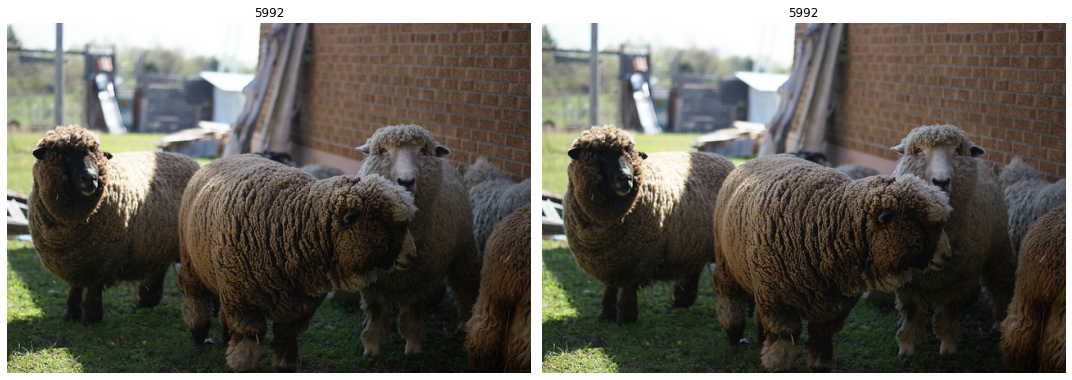

In [32]:
dataset_ids = [56,56]
display_with_dataset_ids(dataset_ids)

In [21]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# define a list of colors for drawing bounding boxes
color_list = ["pink", "black", "blue", "orange", "yellow", "magenta","aqua"]
score_threshold = -4
# len(selected_img_ids) should be even.
def display_coco_image(object_ids, selected_img_ids, dataset_ids):
    # num_imgs_to_disp = 4
    # total_images = len(coco.get_imgIds()) # total number of images
    # sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]
    # img_ids = coco.get_imgIds()
    # selected_img_ids = [img_ids[i] for i in sel_im_idxs]
    ann_ids = coco.get_annIds(selected_img_ids)
    im_licenses = coco.get_imgLicenses(selected_img_ids)
    fig, ax = plt.subplots(nrows=len(selected_img_ids)//2, ncols=2, figsize=(15,10))
    ax = ax.ravel()
            
    for i, im in enumerate(selected_img_ids):
        image = Image.open(f"{coco_images_dir}/{str(im).zfill(12)}.jpg")
        id = dataset_ids[i]
#         pred_logits = deep_ensemble_results[ego_model_index][id]['pred_logits']
#         pred_boxes = deep_ensemble_results[ego_model_index][id]['pred_boxes']
        
#         select_mask = pred_logits > score_threshold
#         select_idx_all = np.reshape(select_mask, -1).nonzero()[0]
#         select_idx = select_idx_all // pred_logits.shape[2]
#         lables = select_idx_all % pred_logits.shape[2]
#         pred_boxes = np.squeeze(pred_boxes[:, select_idx], axis=0)

        pred_logits = deep_ensemble_results[ego_model_index][id]['pred_logits'].squeeze(axis=0)
        pred_boxes = deep_ensemble_results[ego_model_index][id]['pred_boxes'].squeeze(axis=0)
        index_max = np.argmax(pred_logits, axis=1)
        bool_mask = np.ones(pred_logits.shape) * 1000
        for x,y in enumerate(index_max):
            bool_mask[x,y] = 1
        pred_logits = pred_logits * bool_mask

        select_mask = pred_logits > score_threshold
        select_idx_all = np.reshape(select_mask, -1).nonzero()[0]
        select_idx = select_idx_all // pred_logits.shape[1]
        lables = select_idx_all % pred_logits.shape[1]
        pred_boxes = pred_boxes[select_idx]
        lx = dataset_val[id][1]['orig_size'].tolist()
        lx = np.array([lx[1], lx[0], lx[1], lx[0]])
        pred_boxes = pred_boxes * lx
        if len(pred_boxes.shape) > 1:
            pred_boxes[:,:2] = pred_boxes[:,:2] - (pred_boxes[:,2:] / 2)
        object_id = object_ids[i]
        assert object_id < lables.shape[0]
        x, y, w, h = [int(b) for b in pred_boxes[object_id]]
        class_name = coco.load_cats(lables[object_id])[0]["name"]
        color_ = "green"
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
        t_box=ax[i].text(x+w/2, y, class_name,  color=color_, fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        ax[i].add_patch(rect)
        ann_ids = coco.get_annIds(im)
        annotations = coco.load_anns(ann_ids)
        
        ax[i].axis('off')
        ax[i].imshow(image)
        ax[i].set_xlabel('Longitude')
        ax[i].set_title(str(im))
    plt.tight_layout()
    plt.show()

def display_with_dataset_ids(object_ids, dataset_ids):
    selected_img_ids = find_image_ids(dataset_ids)
    print(selected_img_ids)
    display_coco_image(object_ids, selected_img_ids, dataset_ids)

[139, 139]


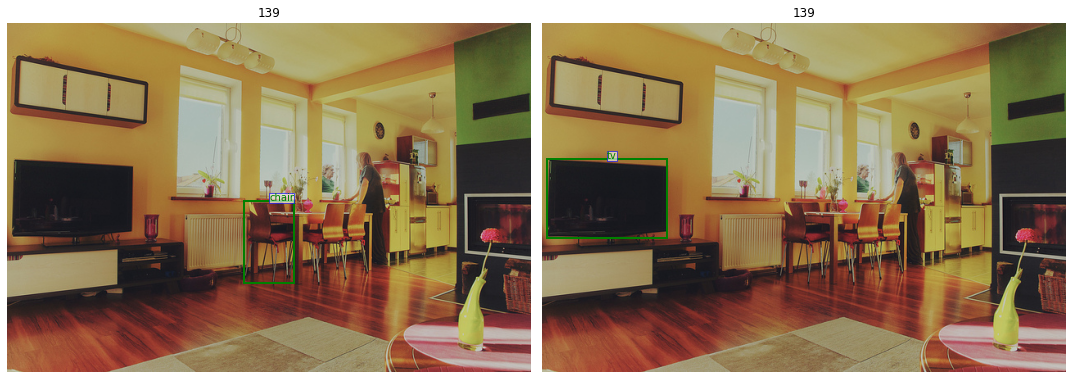

In [22]:
object_ids = [0,1]
dataset_ids = [0,0]
display_with_dataset_ids(object_ids, dataset_ids)

[5992, 5992, 5992, 5992]


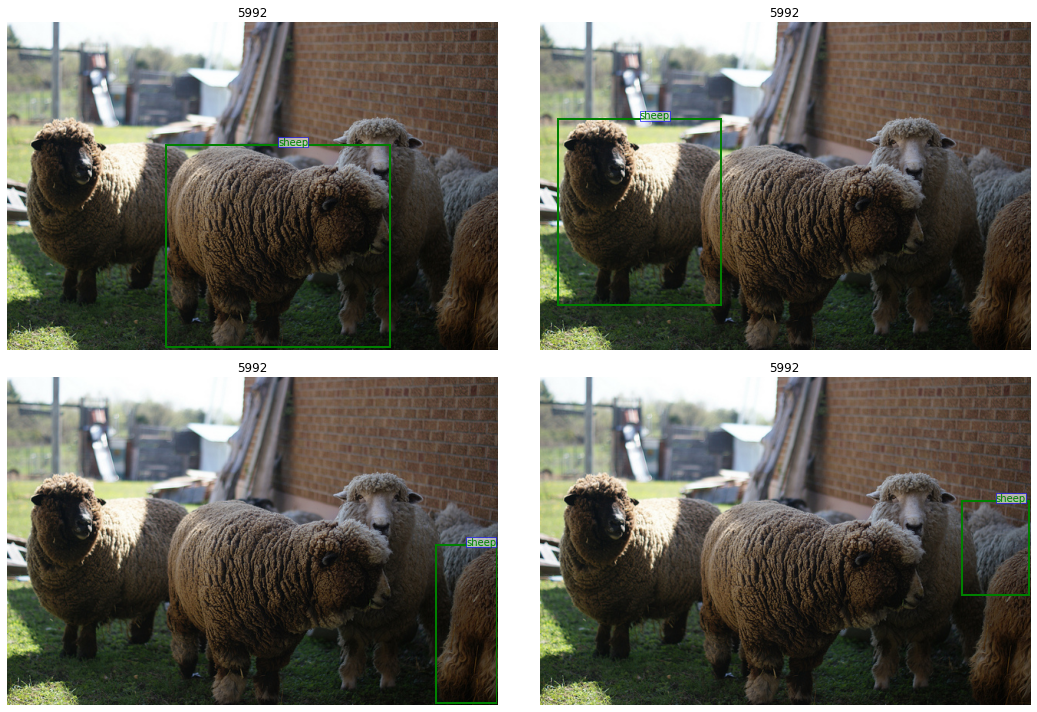

In [74]:
object_ids = [0,1,2,3]
dataset_ids = [56, 56, 56, 56]
display_with_dataset_ids(object_ids, dataset_ids)

[5992, 5992, 5992, 5992]


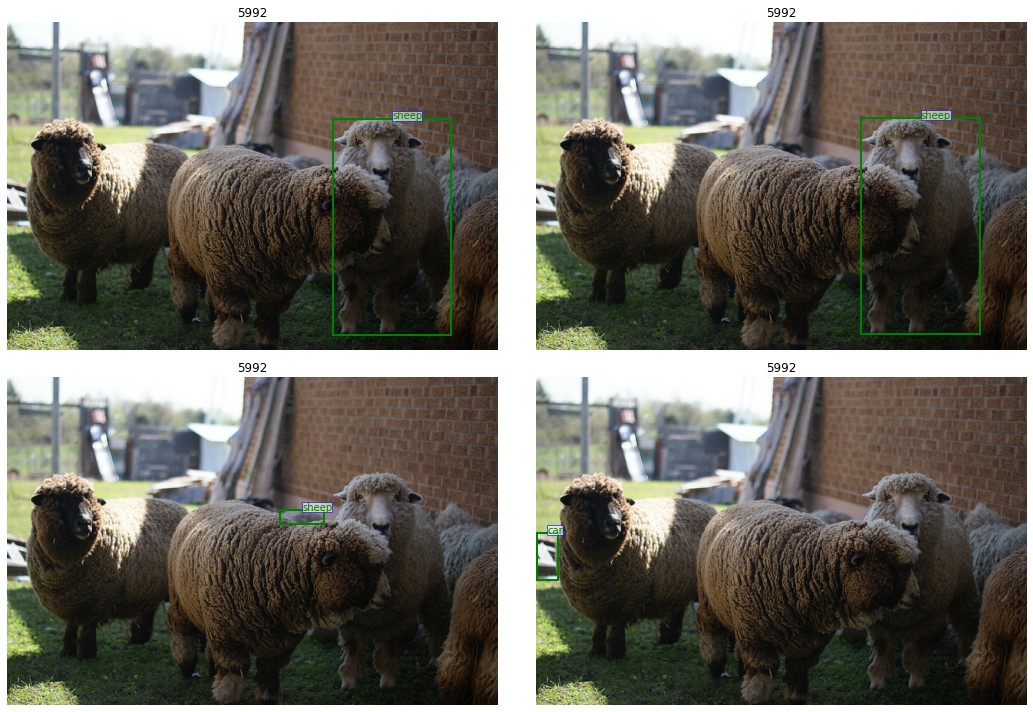

In [75]:
object_ids = [4,5,6,7]
dataset_ids = [56, 56, 56, 56]
display_with_dataset_ids(object_ids, dataset_ids)

[5992, 5992, 5992, 5992]


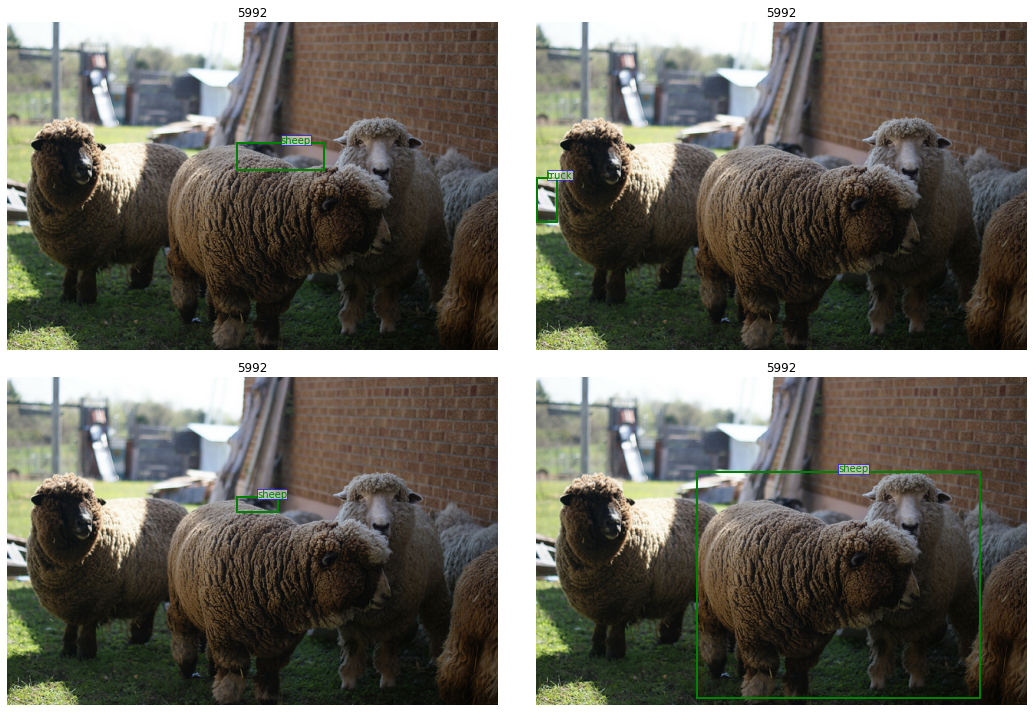

In [76]:
object_ids = [8,9,10,11]
dataset_ids = [56, 56, 56, 56]
display_with_dataset_ids(object_ids, dataset_ids)

[5992, 5992, 5992, 5992]


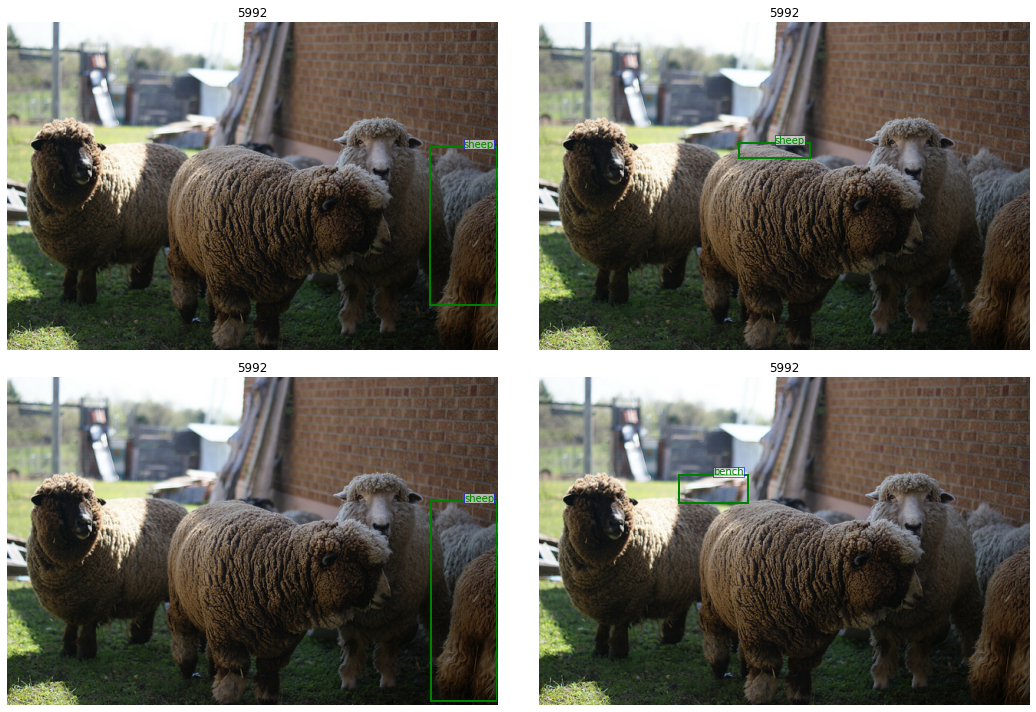

In [77]:
object_ids = [12,13,14,15]
dataset_ids = [56, 56, 56, 56]
display_with_dataset_ids(object_ids, dataset_ids)

[5992, 5992, 5992, 5992]


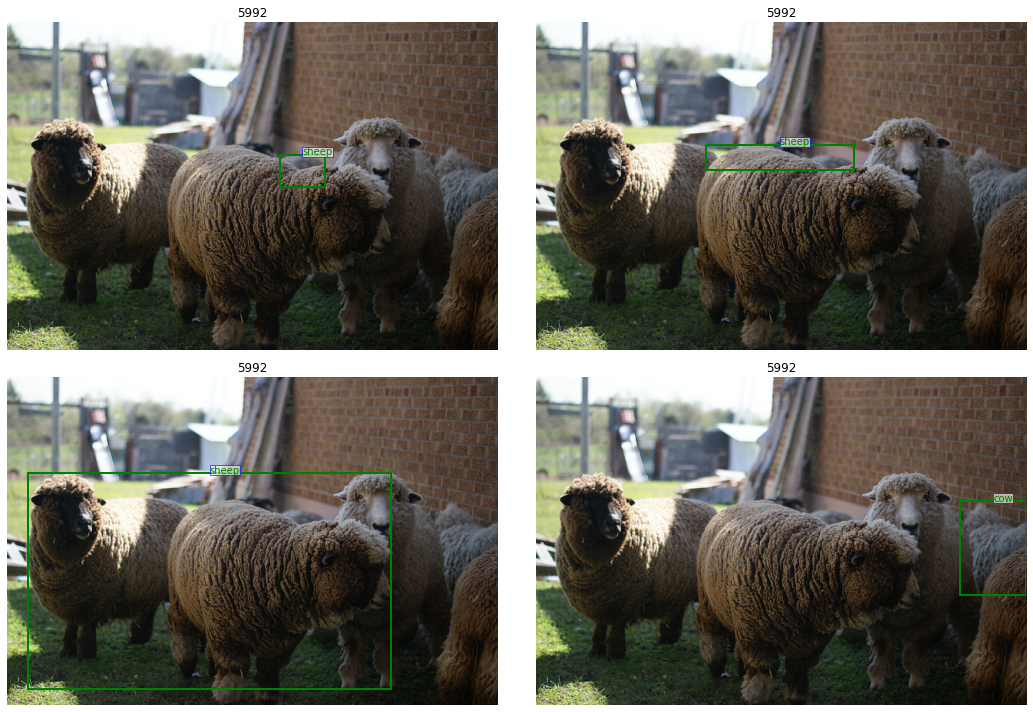

In [78]:
object_ids = [16,17,18,19]
dataset_ids = [56, 56, 56, 56]
display_with_dataset_ids(object_ids, dataset_ids)